In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Mango",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 435 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['diseased', 'healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 0 0 0 0 1]


# Visualize some of the images from our dataset

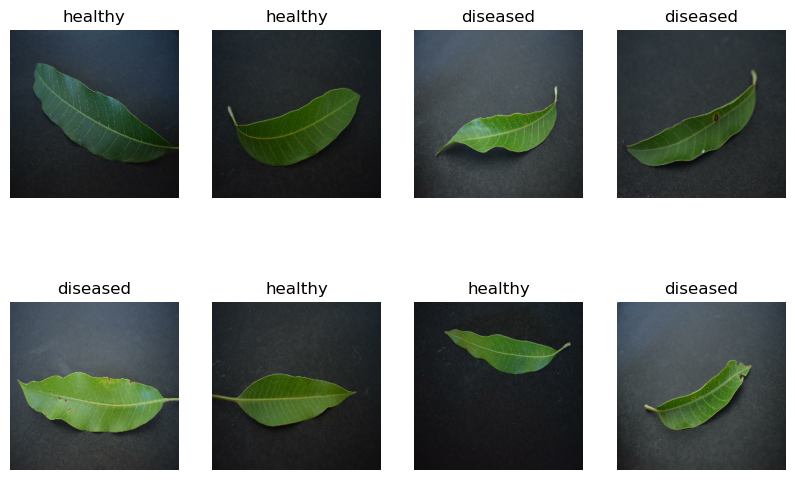

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Divide the Dataset 

In [11]:
image_count=len(dataset)

In [31]:
train_size = int(image_count*0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

In [16]:
print(len(train_ds))
print(len(test_ds))

44
11


# Split the level from the dataset

# Resizing and Normalization

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Augmenttion

In [19]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

In [20]:
# Data augmentation Only on Train data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building 


In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 1

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (8, 127, 127, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (8, 62, 62, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (8, 60, 60, 64)          

# Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [29]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 45s 949ms/step - loss: 0.6353 - accuracy: 0.6165 - val_loss: 0.5701 - val_accuracy: 0.5904
Epoch 2/10
44/44 [==============================] - 43s 943ms/step - loss: 0.5313 - accuracy: 0.7869 - val_loss: 0.5763 - val_accuracy: 0.6627
Epoch 3/10
44/44 [==============================] - 47s 1s/step - loss: 0.2060 - accuracy: 0.9432 - val_loss: 0.4609 - val_accuracy: 0.8675
Epoch 4/10
44/44 [==============================] - 49s 1s/step - loss: 0.1507 - accuracy: 0.9489 - val_loss: 0.0673 - val_accuracy: 0.9880
Epoch 5/10
44/44 [==============================] - 49s 1s/step - loss: 0.0696 - accuracy: 0.9716 - val_loss: 0.0658 - val_accuracy: 0.9759
Epoch 6/10
44/44 [==============================] - 48s 1s/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 7/10
44/44 [==============================] - 47s 1s/step - loss: 0.0303 - accuracy: 0.9886 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 8/10
44/

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

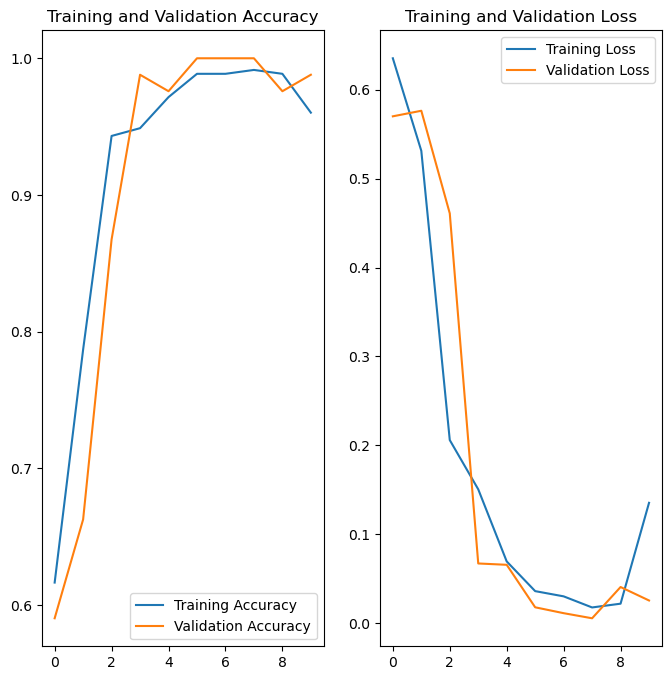

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 10s 103ms/step - loss: 0.0296 - accuracy: 0.9880


In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [40]:
import numpy as np 

1/1 [==============================] - 0s 29ms/step


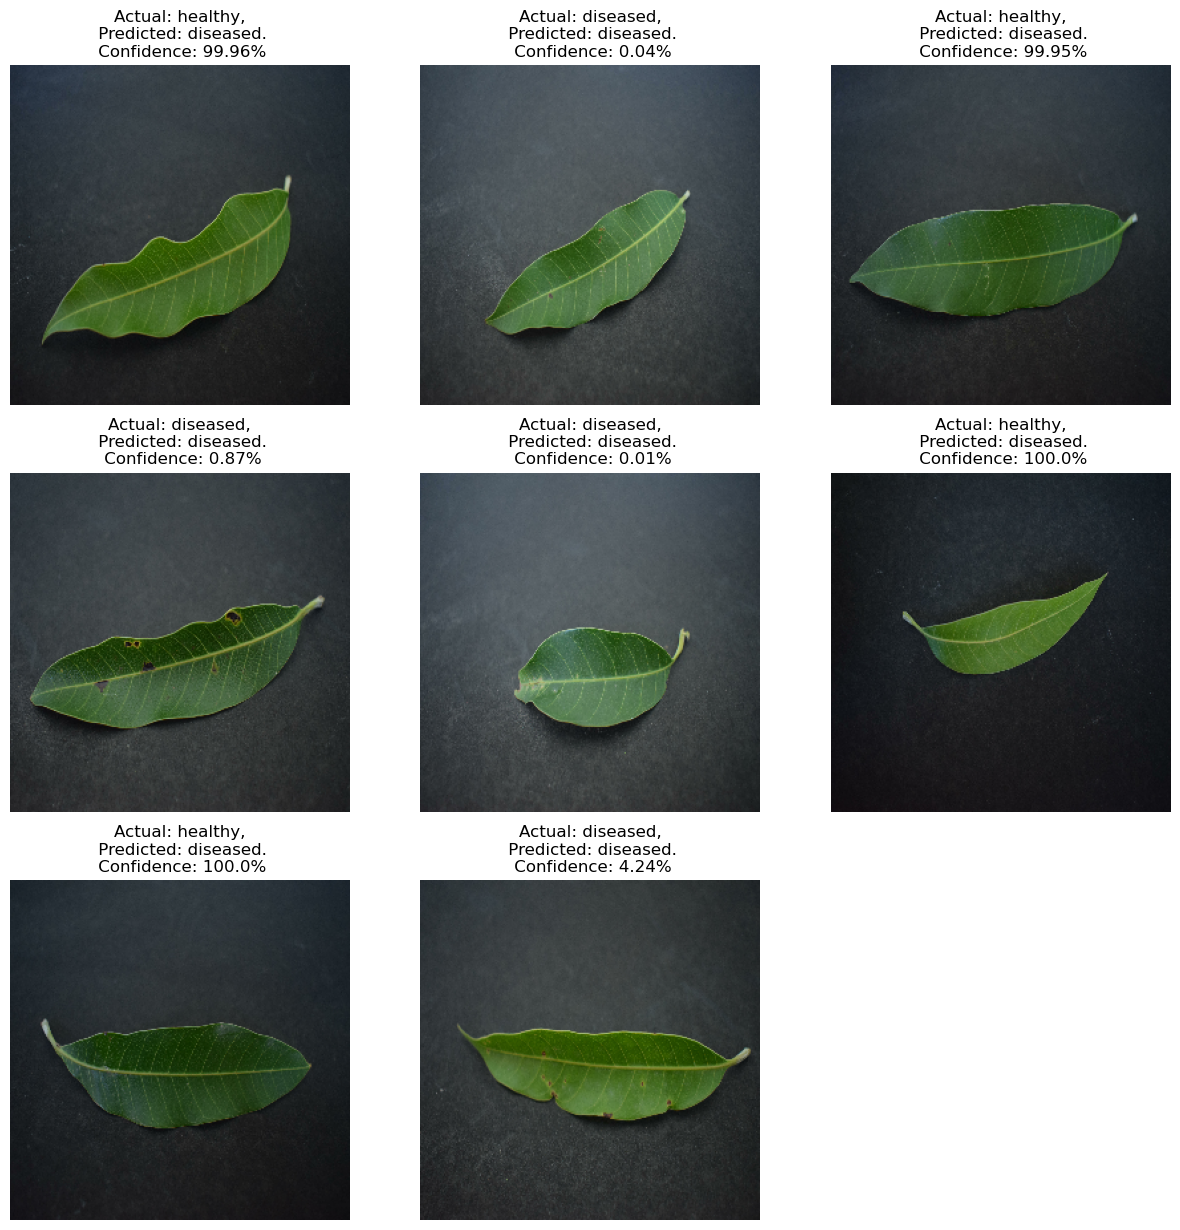

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")